In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/Extracted_IMGs.zip -d /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Functions

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time



In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np


def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[0]
        if(filename.endswith("png")):

          # Check if label ends with "_inc" and modify accordingly
          if filename.endswith('_inc.png'):
              # label = filename[:-4]  # Remove "_inc"
              label += "_inc"

          images.append(img)
          labels.append(label)
    images = np.array(images)

    return images, labels

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np

def load_images_and_labels_f(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[0]
        images.append(img)
        labels.append(label)
    images = np.array(images)

    return images, labels

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(images, labels, test_size=0.2, validation_size=0.1, random_state=42):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state,stratify=labels)

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state,stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_labels= to_categorical(encoded_labels)
    return encoded_labels


In [ ]:
import cv2
import numpy as np

def resize_images_cv2(image_array,wdith,height):
    """
    Resize each image in the input numpy array to 224x224 pixels using cv2.

    Parameters:
    - image_array (numpy.ndarray): Input array of images.

    Returns:
    - resized_images (numpy.ndarray): Array of resized images.
    """
    resized_images = []

    for image in image_array:
        # Resize the image to 224x224 pixels using cv2
        resized_image = cv2.resize(image, (wdith,height))

        resized_images.append(resized_image)

    return np.array(resized_images)

# Example usage:
# Assuming you have a numpy array named 'original_images' containing your images
# resized_images = resize_images_cv2(original_images)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard

def addCallbacks():
  cllbks=[]
  # Define the callback
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',  # You can use 'val_accuracy' or other metrics
      factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
      patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
      min_lr=1e-6,          # Lower bound on the learning rate
      verbose=1
  )
  cllbks.append(reduce_lr)
  # Define the EarlyStopping callback
  early_stopping = EarlyStopping(
          monitor='val_loss',  # Metric to monitor (e.g., validation loss)
          patience=patience,          # Number of epochs with no improvement before stopping
          verbose=1,            # Verbosity level (1 for updates, 0 for silent)
          restore_best_weights=True  # Restore model weights to the best observed during training
          )
  cllbks.append(early_stopping)

  log_dir = save_folder+"Logs/"+model_name
  if not os.path.exists(log_dir):
        os.makedirs(log_dir)
  # print(log_dir)
  tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  # cllbks.append(tensorboard_callback)
  return cllbks
# model_name="aa"
# callbacks=addCallbacks()

In [ ]:
import math

def trainModel(mdl,X_train,y_train,X_val,y_val,cllbk,save_dir):
  steps_per_epoch = math.ceil(len(X_train) / batch_size)
  validation_steps = math.ceil(len(X_val) / batch_size)
  # X_train, X_val, X_test, y_train, y_val, y_test = split_data(Oimages, labels, test_size=0.2, validation_size=0.1, random_state=42)

  # Train the model
  history= mdl.fit(
      X_train,
      y_train,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data=(X_val,y_val),
      validation_steps=validation_steps,
      callbacks=cllbk
  )

  # Save the fine-tuned model
  model.save(save_dir)
  return mdl,history
# callbacks=addCallbacks()
#save_dir = model.save('/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial1-transfer/fine_tuned_densenet121_extracted.h5')
# trainModel(model,X_train,y_train,X_val,y_val,cllbks,save_dir)
#testModel(X_test,y_test)
# testModel(mdl,X_test,y_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def testModel(mdl,X_test,y_test):
  # Assuming you have trained your model and you have X_test and y_test
  # If you have used one-hot encoding for your labels, you might need to convert predictions to class labels
  # Predictions from the model
  y_pred = mdl.predict(X_test)

  # Convert predictions to class labels
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)

  # Calculate metrics
  accuracy = accuracy_score(y_test_labels, y_pred_labels)
  precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
  recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
  f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
  auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

  # Confusion matrix
  conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("AUC:", auc)
  print("Confusion Matrix:\n", conf_matrix)
  return conf_matrix,accuracy,precision,recall,f1
#testModel(X_test,y_test)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(confusion_matrix, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[0])],
                yticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[1])])

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, save_path='confusion_matrix_heatmap_extracted.png')


##CreateModel

In [ ]:
def createModel(imagesize,num_classes,pretrained_model):
  match pretrained_model:
    case "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet169":
      base_model = tf.keras.applications.DenseNet169(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet201":
      base_model = tf.keras.applications.DenseNet201(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionV3":
       base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionResNetV2":
       base_model = tf.keras.applications.InceptionResNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNet":
       base_model = tf.keras.applications.MobileNet(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV2":
       base_model = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV3Small":
      base_model = tf.keras.applications.MobileNetV3Small(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "MobileNetV3Large":
      base_model = tf.keras.applications.MobileNetV3Large(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "NASNetLarge":
       base_model = tf.keras.applications.NASNetLarge(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "NASNetMobile":
       base_model = tf.keras.applications.NASNetMobile(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50":
      base_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
  )
    case "ResNet101":
       base_model = tf.keras.applications.ResNet101(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152":
       base_model = tf.keras.applications.ResNet152(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50V2":
       base_model = tf.keras.applications.ResNet50V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101V2":
       base_model = tf.keras.applications.ResNet101V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152V2":
       base_model = tf.keras.applications.ResNet152V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG16":
       base_model = tf.keras.applications.VGG16(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG19":
       base_model = tf.keras.applications.VGG19(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "Xception":
       base_model = tf.keras.applications.Xception(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case _ :
      exit()


  for layer in base_model.layers:
    layer.trainable = False

  model = models.Sequential([
      base_model,
      layers.GlobalMaxPool2D(),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='softmax')
  ])



  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
#createModel(imagesize,num_classes,pretrained_model)
#createDenseNet121((224, 224, 3),num_classes)

In [ ]:
import pandas as pd

def create_empty_csv_file(file_path):
    """
    Create an empty CSV file with row headers.

    The row headers are: Model Name, Accuracy, Precision, Recall, F1-Score, Testing Time, Training Time

    Parameters:
    - file_path: The file path where the CSV file will be saved.
    """

    # Create an empty DataFrame with the specified headers
    headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time']
    df = pd.DataFrame(columns=headers)

    # Save to CSV file
    df.to_csv(file_path, index=False)

    print(f"Empty CSV file '{file_path}' created successfully.")

# Example usage:
# csv_file_path = "empty_evaluation_metrics.csv"
# create_empty_csv_file(csv_file_path)


In [ ]:
import pandas as pd

def append_to_csv(file_path, model_name, accuracy, precision, recall, f1_score, testing_time, training_time):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time']
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.Series({'Model Name': model_name,
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1-Score': f1_score,
                        'Testing Time': testing_time,
                        'Training Time': training_time})

    # df=pd.concat(new_row, ignore_index=True)
    df = df.append(new_row, ignore_index=True)

    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)


In [ ]:
def runModel(model_name):
  save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
  model=createModel(img_size,num_classes,model_name)
  callbacks=addCallbacks()
  model.summary()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  print(f"Training Time taken: {durationt} seconds")
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
  append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)
#runModel("X")

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

def visualize_model_architecture(model,filename=save_folder+'model_architecture.png'):
    """
    Visualizes the architecture of a Keras model and saves the visualization to a file.

    Args:
        model (tf.keras.Model): The Keras model to visualize.
        filename (str): The filename to save the visualization. Default is 'model_architecture.png'.
    """
    print(filename)
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    del model


#Paramters

In [ ]:
batch_size = 64
num_classes = 20  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=25
img_size=(width, height, 3)
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/'
csv_file_path=save_folder+"results.csv"
# create_empty_csv_file(save_folder+"results.csv")

In [ ]:
m=createModel(img_size,num_classes,"DenseNet121")
visualize_model_architecture(m,filename=save_folder+'dense_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/dense_model_architecture.png


# Transfer Learning Extracted Features Images

##Load Data

In [ ]:
Oimages, Olabels = load_images_and_labels_f('/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/Extracted_IMGs')

Loading Images: 100%|██████████| 2000/2000 [00:45<00:00, 44.10it/s] 


##Preprocess Data

In [ ]:
labels = encode_labels(Olabels)  # Add your label encoding function

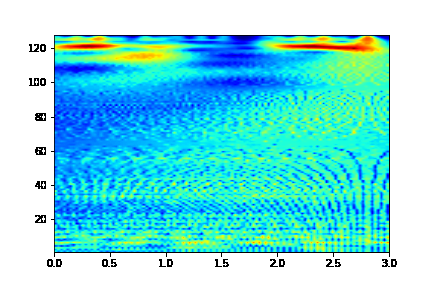

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(Oimages[0])

In [ ]:
resized_images = resize_images_cv2(Oimages,width, height)
resized_images[0].shape

(224, 224, 3)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_images, labels, test_size=0.2, validation_size=0.1, random_state=42)


In [ ]:
del Oimages,Olabels,resized_images,labels

##DenseNet

###DenseNet121

In [ ]:
model_name="DenseNet121"
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2-transfer/'
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1050.9030530452728 seconds


13/13 [==============================] - 7s 215ms/step
Accuracy: 0.8725
Precision: 0.8774694212717331
Recall: 0.8725
F1 Score: 0.8697504379583723
AUC: 0.9955986842105263
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0 16  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  1  0  0  0  0  0  0  0  2  1  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 13  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  1  0  0  0  0  0  4  0]
 [ 0  1  0  0  0  0  0  0  1  0 13  0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  1  0  0  0 14  0  0  0  0  0

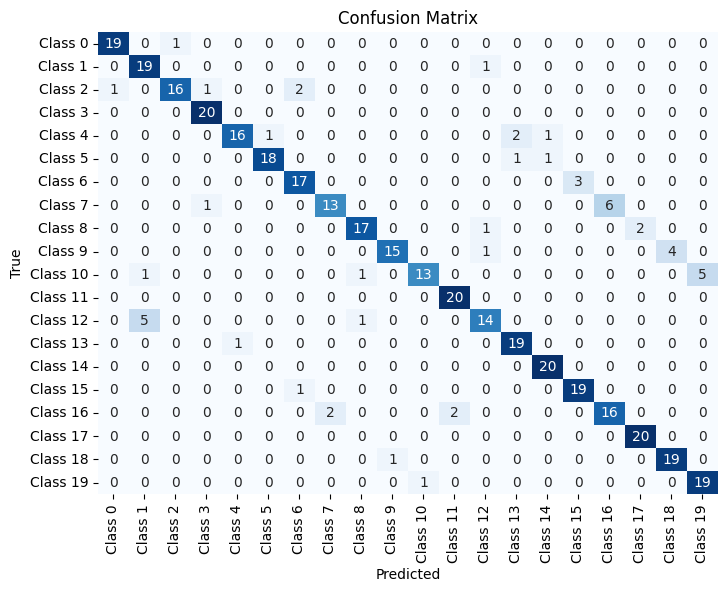

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')


In [ ]:
import pandas as pd
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###DenseNet169

In [ ]:
del model

In [ ]:
model_name="DenseNet169"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

51877672/51877672 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 1664)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_1 (Flatten)         (None, 1664)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               852480    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1131.0718007087708 seconds


13/13 [==============================] - 6s 166ms/step
Accuracy: 0.8475
Precision: 0.8532543479911903
Recall: 0.8475
F1 Score: 0.8462633914814313
AUC: 0.9938486842105261
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 1  0 17  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  1  2  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  2  0  0  0 13  0  0  0  1  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  1  1  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0]
 [ 0  2  0  0  0  0  0  0  2  0 12  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  1  0 14  0  0  0  0  0

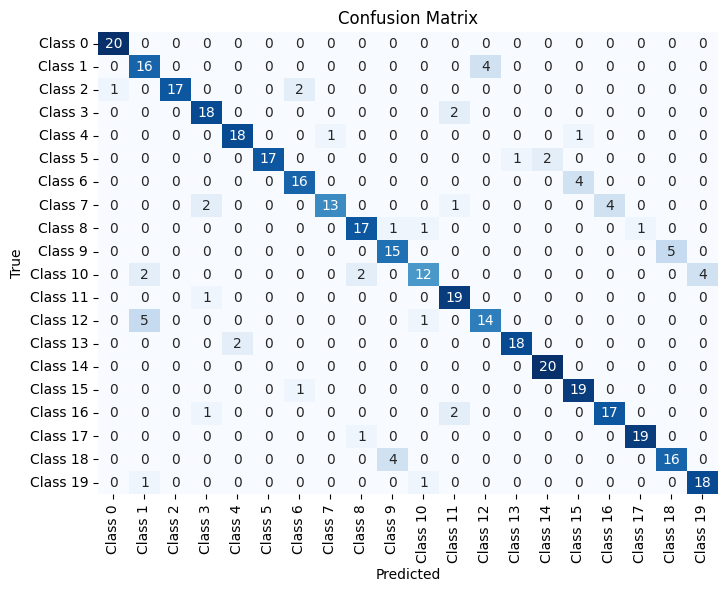

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###DenseNet201

In [ ]:
del model

In [ ]:
model_name="DenseNet201"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

74836368/74836368 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1920)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               983552    
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1355.1283776760101 seconds


13/13 [==============================] - 8s 207ms/step
Accuracy: 0.8475
Precision: 0.8508332848949859
Recall: 0.8475
F1 Score: 0.844935831636805
AUC: 0.9944473684210526
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 2  0 17  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  3  1  0  0  0  1  0]
 [ 0  0  0  0  1 15  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  1  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  2  0 11  0  0  0  0  0  0  1  0  6]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  1  0  0  0 14  0  0  0  0  0 

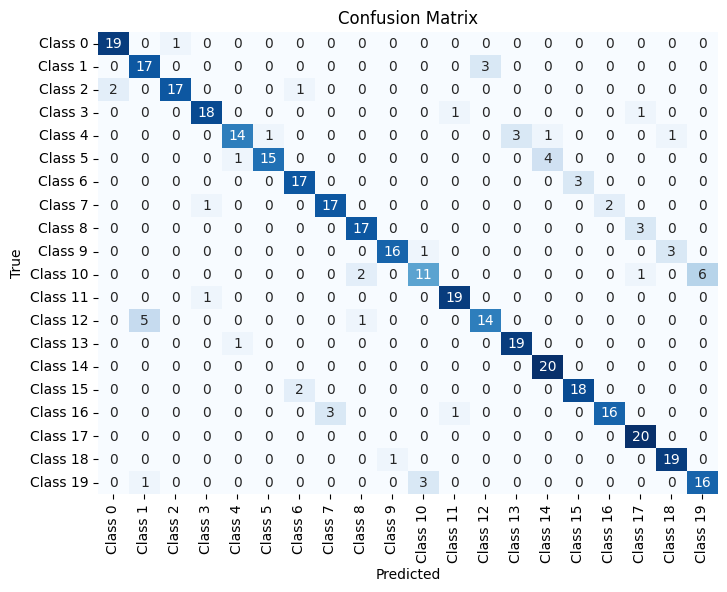

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##Xception

In [ ]:
del model

In [ ]:
model_name="Xception"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

83683744/83683744 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_3 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1587.9400479793549 seconds


13/13 [==============================] - 5s 203ms/step
Accuracy: 0.8525
Precision: 0.8599216508876626
Recall: 0.8525
F1 Score: 0.8499274394736281
AUC: 0.9943026315789474
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 1  0 18  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  1  5  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  1  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  1 14  0  0  1  0  0  0  0  0  4  0]
 [ 0  2  0  0  0  0  0  0  2  0 13  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0

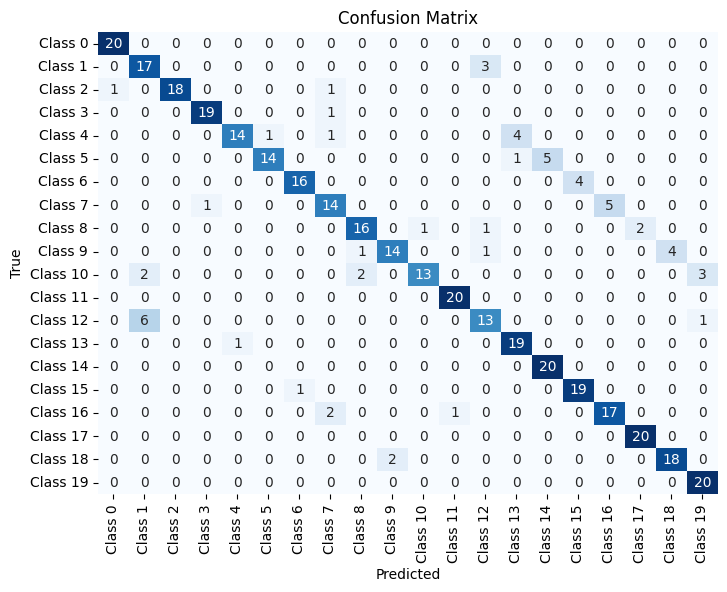

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##VGG

####VGG16

In [ ]:
del model

In [ ]:
model_name="VGG16"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d_4 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_8 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 716.8112368583679 seconds


13/13 [==============================] - 7s 271ms/step
Accuracy: 0.9
Precision: 0.9041739972460796
Recall: 0.9
F1 Score: 0.8996018230889264
AUC: 0.9948815789473684
Confusion Matrix:
 [[18  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 15  2  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  1  2  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0 16  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0

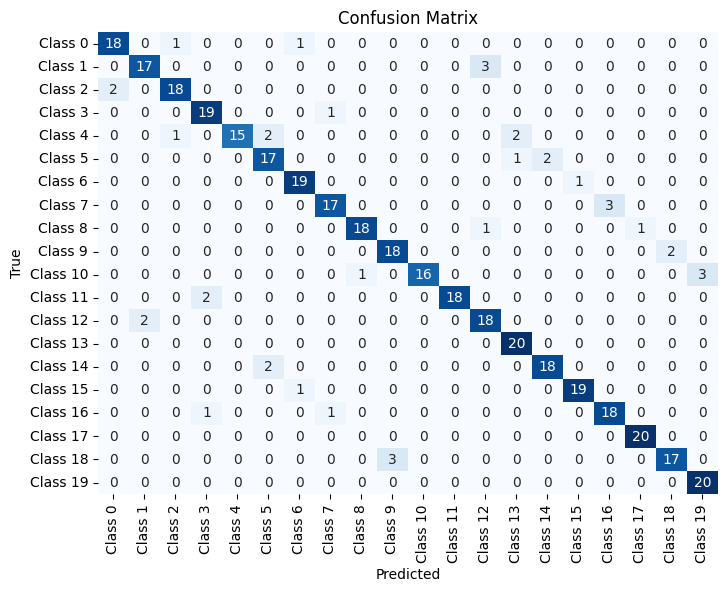

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


####VGG19

In [ ]:
del model

In [ ]:
model_name="VGG19"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

80134624/80134624 [==============================] - 5s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_max_pooling2d_5 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 750.957671880722 seconds


13/13 [==============================] - 2s 142ms/step
Accuracy: 0.8675
Precision: 0.8737999888398494
Recall: 0.8675
F1 Score: 0.8666897542193351
AUC: 0.9938486842105263
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  1  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  2  0  0  0  0  0  0  2  0 15  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0

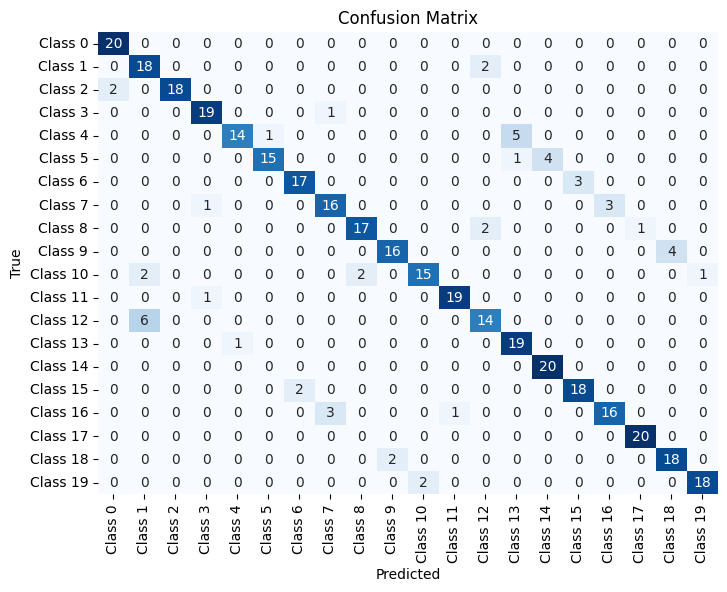

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##NasNet

###NASNetLarge

In [ ]:
del model

In [ ]:
model_name="NASNetLarge"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

343610240/343610240 [==============================] - 4s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_max_pooling2d_4 (Gl  (None, 4032)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_4 (Flatten)         (None, 4032)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               2064896   
                                                                 
 batch_normalization_301 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                     

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-484661b08cb6>", line 7, in <cell line: 7>
    model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  File "<ipython-input-9-07d9e7758f63>", line 9, in trainModel
    history= mdl.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1850, in fit
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 453, in on_epoch_end
    callback.on_epoch_end(epoch, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 2844, in on_epoch_end
    self._log_weights(epoch)
  File "/

TypeError: ignored

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-16-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###NASNetMobile

In [ ]:
del model

In [ ]:
model_name="NASNetMobile"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

19993432/19993432 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1056)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_3 (Flatten)         (None, 1056)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               541184    
                                                                 
 batch_normalization_300 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1507.4655396938324 seconds


13/13 [==============================] - 5s 106ms/step
Accuracy: 0.7625
Precision: 0.7637751129726327
Recall: 0.7625
F1 Score: 0.7544784241413115
AUC: 0.9862368421052631
Confusion Matrix:
 [[17  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  3]
 [ 1  0 18  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  2  0  0  1  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  1  0  0  0  0  0  2  1  1  0  0  0  0]
 [ 0  0  0  0  1 15  0  0  0  0  0  0  0  1  3  0  0  0  0  0]
 [ 0  0  1  0  0  0 14  0  0  0  0  0  0  1  0  4  0  0  0  0]
 [ 0  0  0  1  0  0  0 10  0  1  0  1  0  0  0  0  6  0  1  0]
 [ 0  0  0  0  0  0  0  0 11  1  1  0  1  0  0  0  0  5  0  1]
 [ 0  0  0  0  0  0  0  0  1 13  0  0  0  0  0  0  1  0  5  0]
 [ 0  1  0  0  0  0  0  0  1  2  6  0  3  0  0  0  0  1  0  6]
 [ 0  0  0  3  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  1  0  1  0 11  0  0  0  0  4

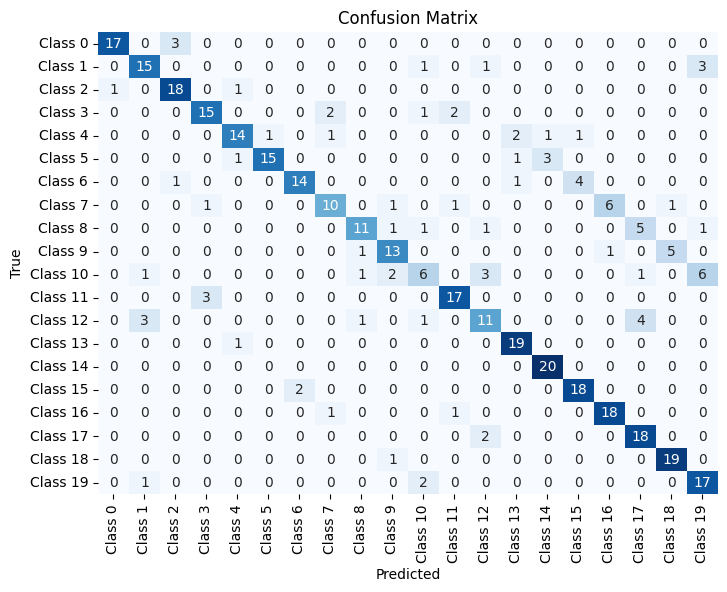

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##ResNet

###ResNet50

In [ ]:
del model

In [ ]:
model_name="ResNet50"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_6 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_10 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 748.874419927597 seconds


13/13 [==============================] - 4s 142ms/step
Accuracy: 0.89
Precision: 0.8957945952807307
Recall: 0.89
F1 Score: 0.8885769813101365
AUC: 0.9962500000000001
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 2  0 15  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  1  0  0  0  0  0  0  1  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0]
 [ 0  1  0  0  0  0  0  0  1  0 14  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  4  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0 

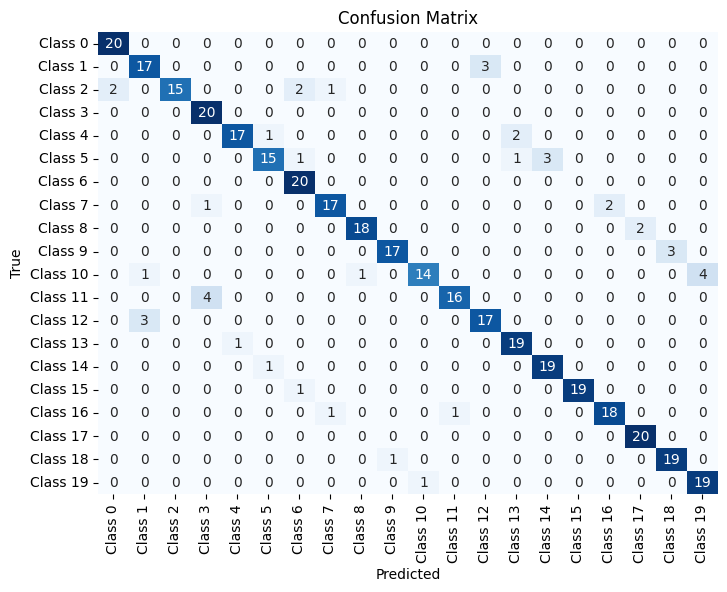

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet101

In [ ]:
del model

In [ ]:
model_name="ResNet101"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

171446536/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 2546.223854780197 seconds


13/13 [==============================] - 6s 220ms/step
Accuracy: 0.9
Precision: 0.9035751197192002
Recall: 0.9
F1 Score: 0.8987782227430554
AUC: 0.9969868421052634
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0 18  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  2  0  0  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  2  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  2  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0 15  0  1  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0

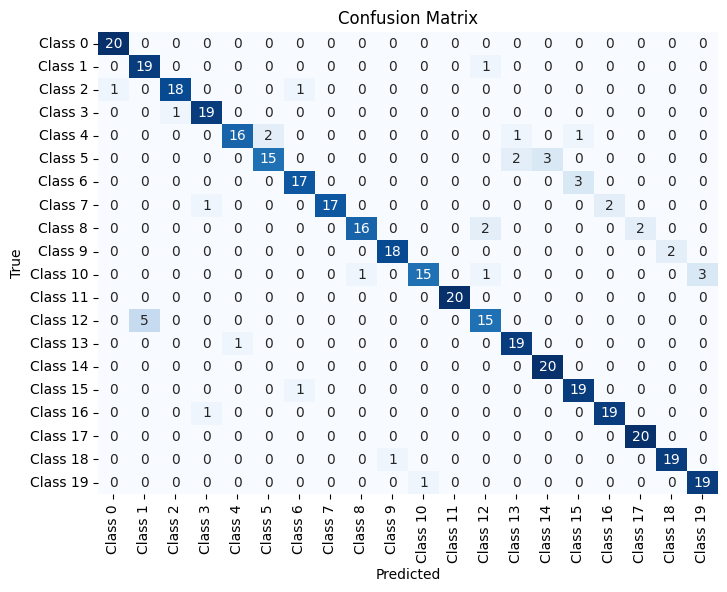

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-15-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet152

In [ ]:
del model

In [ ]:
model_name="ResNet152"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

234698864/234698864 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1713.3097310066223 seconds


13/13 [==============================] - 5s 244ms/step
Accuracy: 0.8825
Precision: 0.888063985807794
Recall: 0.8825
F1 Score: 0.8798612788180862
AUC: 0.9956776315789474
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 17  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1 15  0  0  0  0  0  0  0  1  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  2  0 12  0  0  0  0  0  0  1  0  5]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  1  0  0  0 13  0  0  0  0  1 

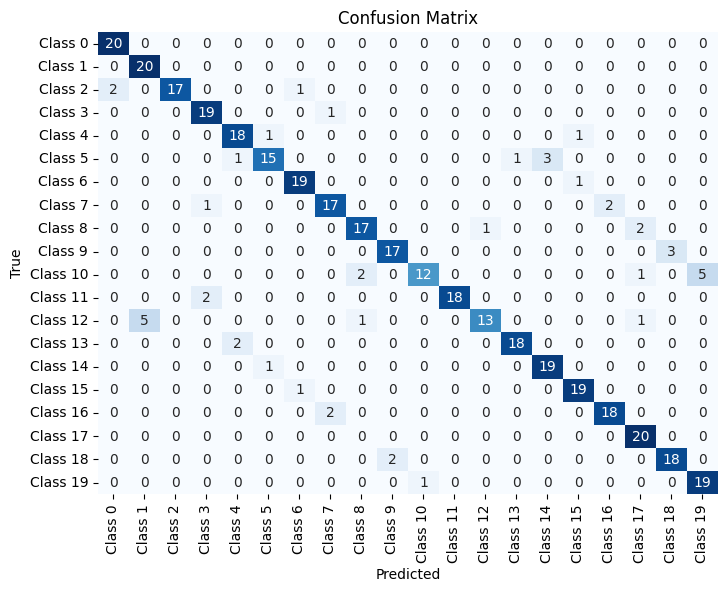

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-15-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet50V2

In [ ]:
del model

In [ ]:
model_name="ResNet50V2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1286.427171945572 seconds


13/13 [==============================] - 3s 133ms/step
Accuracy: 0.8525
Precision: 0.8595322201124632
Recall: 0.8525
F1 Score: 0.8497695868889305
AUC: 0.9936381578947369
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  0 16  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  1  0  1  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  1  4  0  0  0  0  0]
 [ 0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  1  0  1  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  1  0  0  0  0  0  0  1  0 13  0  0  0  0  0  0  0  0  5]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0

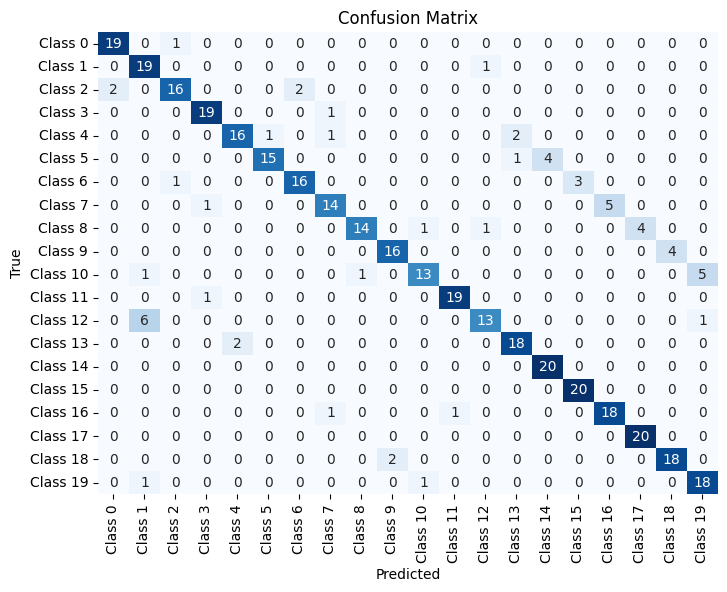

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-15-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet101V2

In [ ]:
del model

In [ ]:
model_name="ResNet101V2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

171317808/171317808 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_max_pooling2d_3 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 2977.851964712143 seconds


13/13 [==============================] - 4s 165ms/step
Accuracy: 0.78
Precision: 0.7960794050764101
Recall: 0.78
F1 Score: 0.7722213225010438
AUC: 0.9891776315789473
Confusion Matrix:
 [[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 2  0 16  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  1 11  0  0  0  0  0  0  0  2  6  0  0  0  0  0]
 [ 1  0  1  0  0  0 13  0  0  0  0  0  0  1  0  4  0  0  0  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  2  0  3  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  1  0  0  0  0  0  9  0]
 [ 0  1  0  0  0  0  0  0  2  0 11  0  1  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  1  0 12  0  0  0  0  0  0 

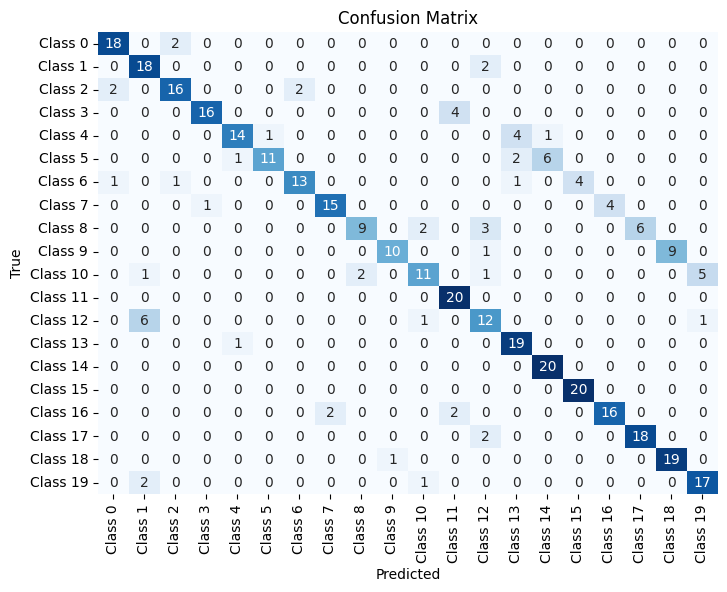

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-15-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet152V2

In [ ]:
del model

In [ ]:
model_name="ResNet152V2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

234545216/234545216 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 3268.891236305237 seconds


13/13 [==============================] - 7s 287ms/step
Accuracy: 0.785
Precision: 0.7943148040831108
Recall: 0.785
F1 Score: 0.7831201622085848
AUC: 0.9897763157894737
Confusion Matrix:
 [[17  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  1]
 [ 1  0 16  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  3 12  0  0  0  0  0  0  0  1  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  2  0  2  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  1  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  2  0 11  0  1  0  0  0  0  0  0  6]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  1  0  1  0 12  0  0  0  0  0  

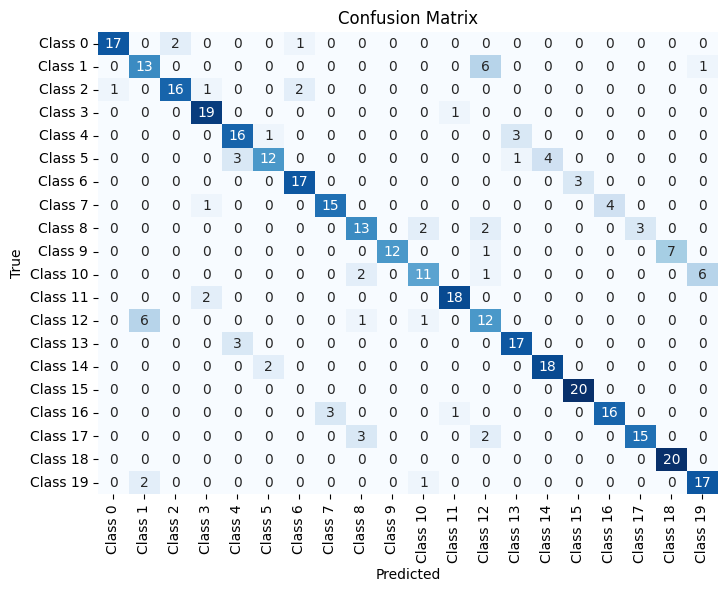

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##Inception

###InceptionV3

In [ ]:
del model

In [ ]:
model_name="InceptionV3"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_95 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1107.423043012619 seconds


13/13 [==============================] - 4s 142ms/step
Accuracy: 0.8625
Precision: 0.866832136918286
Recall: 0.8625
F1 Score: 0.8611342411011038
AUC: 0.9951250000000001
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 1  0 16  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  1  0  0  0  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  0  0  0  0  0  1  2  0  0  0  0  0]
 [ 0  0  1  0  0  0 16  0  0  0  1  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  2  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  1  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  1  0 13  0  1  0  0  0  0  0  0  5]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0 

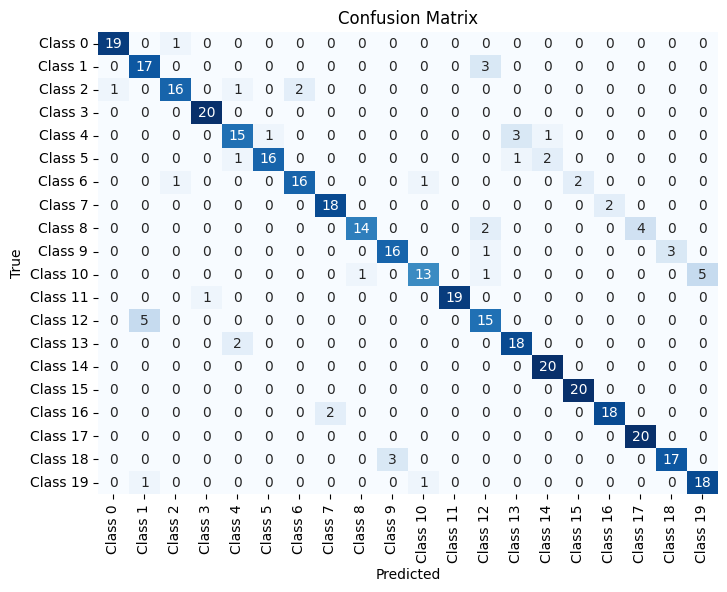

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###InceptionResNetV2

In [ ]:
del model

In [ ]:
model_name="InceptionResNetV2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1536)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               786944    
                                                                 
 batch_normalization_299 (B  (None, 512)               2048      
 atchNormalization)                                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 2754.7806389331818 seconds


13/13 [==============================] - 8s 218ms/step
Accuracy: 0.5375
Precision: 0.5533240977111212
Recall: 0.5375
F1 Score: 0.5193477714255816
AUC: 0.9647631578947369
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  5  0  3  0  2  0  0  0  0  1  0  2]
 [ 6  0 12  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  2  0  0  0  5  0  0  0  0  1  0  1  0]
 [ 0  0  1  0  7  0  1  0  0  0  0  0  0  9  2  0  0  0  0  0]
 [ 0  0  0  0  3  6  0  0  0  0  0  0  0  3  8  0  0  0  0  0]
 [ 2  0  2  0  0  0  8  0  0  0  0  0  0  1  0  7  0  0  0  0]
 [ 0  0  0  6  0  0  0  4  2  0  0  2  0  0  0  0  5  0  1  0]
 [ 0  3  0  0  0  0  0  0  7  0  2  0  0  0  0  0  0  6  0  2]
 [ 0  0  0  0  0  0  0  0  5  8  1  0  0  0  0  0  0  0  6  0]
 [ 0  4  0  0  0  0  0  0  0  0  3  0  1  0  0  0  0  1  0 11]
 [ 0  0  0  2  0  0  0  0  0  0  0 16  0  0  0  0  2  0  0  0]
 [ 0  8  0  0  0  0  0  0  2  0  1  0  5  0  0  0  0  4

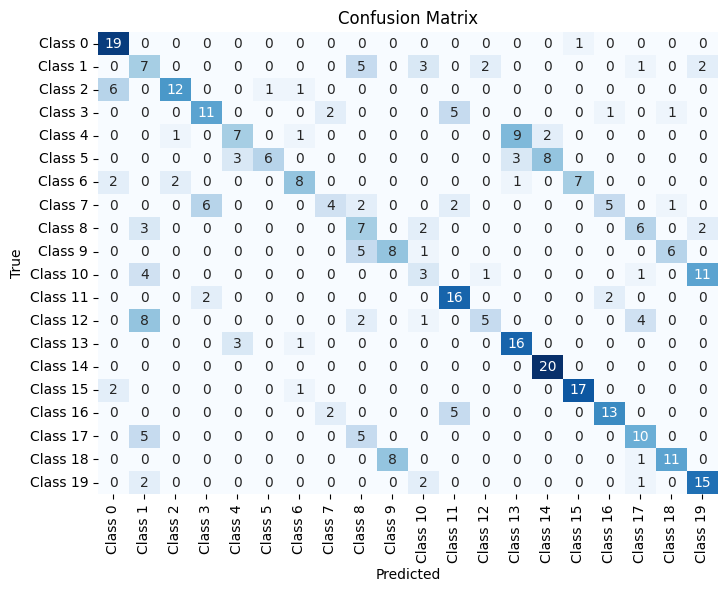

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##MobileNet

###MobileNet

In [ ]:
del model

In [ ]:
model_name="MobileNet"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_max_pooling2d_5 (Gl  (None, 1024)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_302 (B  (None, 512)               2048      
 atchNormalization)                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1030.1579506397247 seconds


13/13 [==============================] - 2s 58ms/step
Accuracy: 0.8125
Precision: 0.8217090912555395
Recall: 0.8125
F1 Score: 0.8083704239835025
AUC: 0.9885197368421051
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 1  0 18  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  1  0  1  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0 10  1  0  0  0  0  0  0  0  5  2  0  0  1  0  1]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  1  7  0  0  0  0  0]
 [ 0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  1  2  0  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  2  0  1  0  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  1 15  0  0  0  0  0  0  0  0  4  0]
 [ 0  1  0  0  0  0  0  0  1  0 15  0  0  0  0  0  0  1  0  2]
 [ 0  0  0  5  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  1  0 16  0  0  0  0  0 

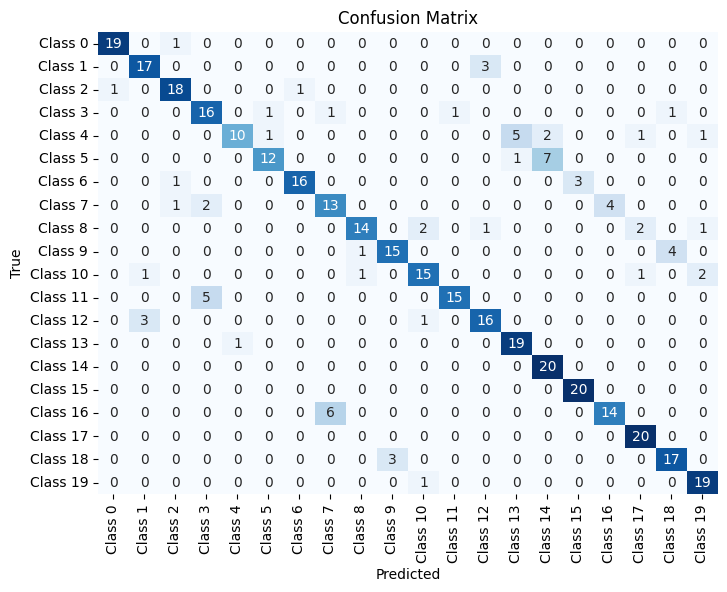

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###MobileNetV2

In [ ]:
del model

In [ ]:
model_name="MobileNetV2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_6 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_303 (B  (None, 512)               2048      
 atchNormalization)                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 213.4654016494751 seconds


13/13 [==============================] - 2s 65ms/step
Accuracy: 0.805
Precision: 0.822681450542199
Recall: 0.805
F1 Score: 0.8000990271885624
AUC: 0.9899144736842105
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 1  0 16  0  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  1  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0]
 [ 0  0  0  0  6  8  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  3  0  0  0 12  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  1  0  0  3  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  3  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  2  0 12  0  3  0  0  0  0  1  0  2]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0 

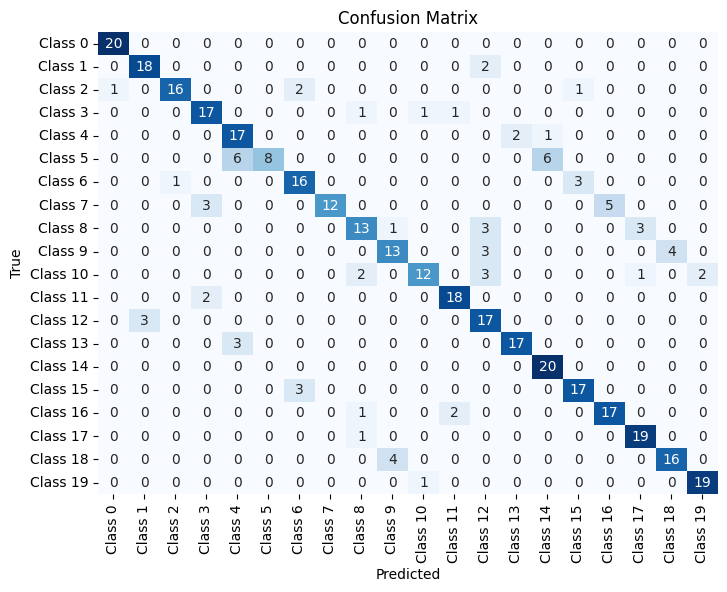

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###MobileNetV3Small

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Small"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

4334752/4334752 [==============================] - 0s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_max_pooling2d_7 (Gl  (None, 576)               0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_7 (Flatten)         (None, 576)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               295424    
                                                                 
 batch_normalization_304 (B  (None, 512)               2048      
 atchNormalization)                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 93.76642322540283 seconds


13/13 [==============================] - 3s 61ms/step
Accuracy: 0.8825
Precision: 0.887987327129355
Recall: 0.8825
F1 Score: 0.881243629007345
AUC: 0.9955263157894734
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  2  3  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0 16  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  1  0 16  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0

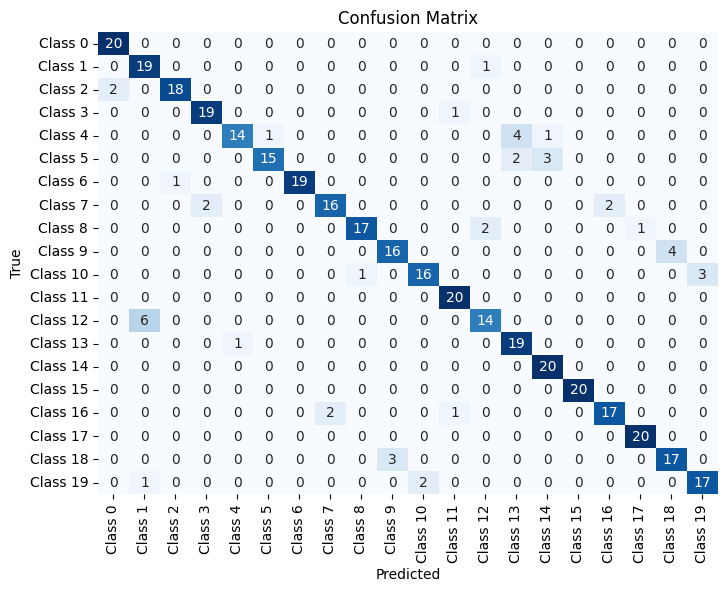

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###MobileNetV3Large

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Large"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

12683000/12683000 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_max_pooling2d_8 (Gl  (None, 960)               0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_8 (Flatten)         (None, 960)               0         
                                                                 
 dense_24 (Dense)            (None, 512)               492032    
                                                                 
 batch_normalization_305 (B  (None, 512)               2048      
 atchNormalization)                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 151.33161997795105 seconds


13/13 [==============================] - 2s 66ms/step
Accuracy: 0.8875
Precision: 0.8951982005651576
Recall: 0.8875
F1 Score: 0.8859139392073203
AUC: 0.9953749999999998
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  0 17  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  1  0  0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  2  0  0  0 16  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  1  0  0  2  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0]
 [ 0  1  0  0  0  0  0  0  1  0 14  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0 

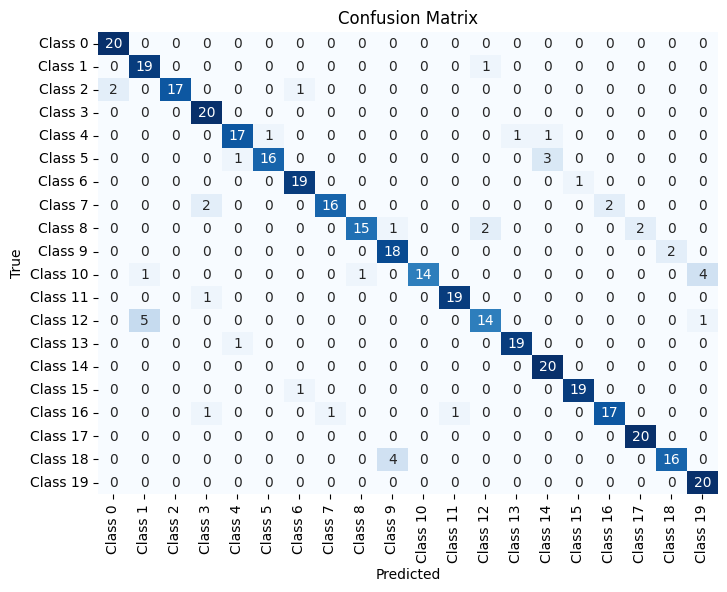

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
